In [37]:
from vnstock import Vnstock
from vnstock import Listing, Quote, Company, Finance, Trading, Screener 

In [38]:
#Import all packages
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
import statsmodels.formula.api as smf
pd.options.mode.chained_assignment = None
import requests
import matplotlib.pyplot as plt
from math import floor
from termcolor import colored as cl
import datetime as dt
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt
import bs4 as bs
import requests
from IPython.display import clear_output
from scipy.stats import mstats
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import RandomizedSearchCV, validation_curve, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pickle
import os
from sklearn.model_selection import GridSearchCV
sns.set()

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

In [ ]:
#Get list of tickers from HOSE (Retry this later when you have time)
df = stock.screener.stock(params={"exchangeName": "HOSE"}, limit=1700)
tickers = df['ticker'].dropna().unique().tolist()

In [39]:
#Test step 1 with VN30 tickers
df = pd.read_excel(r"c:\Users\Khoa Hoang\Downloads\VN30 code.xlsx")
df.columns = df.columns.str.strip()  # Clean column names (remove extra spaces)
tickers = df['Stock code'].astype(str).tolist()
print(tickers)

['POW', 'HPG', 'SSI', 'VPB', 'STB', 'MBB', 'MWG', 'TCH', 'BVH', 'VHM', 'HDB', 'PDR', 'TCB', 'CTG', 'VRE', 'REE', 'NVL', 'VNM', 'BID', 'VIC', 'FPT', 'PLX', 'VCB', 'SBT', 'KDH', 'MSN', 'PNJ', 'TPB', 'VJC', 'GAS']


In [40]:
# Collect historical price data
all_data = []

for ticker in tickers:
    try:
        s = Vnstock().stock(symbol=ticker, source="VCI")
        data = s.quote.history(start='2020-01-01', end='2025-05-19')
        data['ticker'] = ticker
        all_data.append(data)
    except Exception as e:
        print(f"Data retrieval error {ticker}: {e}")

# Combine and process
stocks = pd.concat(all_data, ignore_index=True)
stocks['time'] = pd.to_datetime(stocks['time'])
stocks.sort_values(by=['ticker', 'time'], inplace=True)
stocks['close'] = pd.to_numeric(stocks['close'], errors='coerce')
stocks['returns'] = stocks.groupby('ticker')['close'].pct_change()

# View result
print(stocks.head())

            time   open   high    low  close   volume ticker   returns
24102 2020-01-02  26.25  26.94  26.20  26.77   872620    BID       NaN
24103 2020-01-03  27.02  27.11  26.65  26.65   603940    BID -0.004483
24104 2020-01-06  26.54  26.65  26.14  26.14   794490    BID -0.019137
24105 2020-01-07  26.14  26.65  25.80  26.65   526890    BID  0.019510
24106 2020-01-08  26.25  27.34  26.14  26.88  1230830    BID  0.008630


In [41]:
stocks['time'] = pd.to_datetime(stocks['time'])
stocks.sort_values(by=['ticker', 'time'], inplace=True)

## TECHNICAL INDICATOR

## Simple Moving Average (Price)

In [42]:
#Short term window Moving Avg (1 trading week)
stocks['SMA_5'] = stocks.groupby('ticker')['close'].transform(lambda x: x.rolling(window = 5).mean())
#Long term window Moving Avg (1 trading month)
stocks['SMA_20'] = stocks.groupby('ticker')['close'].transform(lambda x: x.rolling(window = 20).mean())
#Check for Golden Cross (when short term moving average crosses above long term), aka: when the ratio < 1
stocks['SMA_Ratio'] = stocks['SMA_20'] / stocks['SMA_5']

#Strategy:
#If SMA_Ratio < 1 THEN BUY

#Create a position column where (1=buy, 0=hold, -1=sell)
stocks['SMA_Indicator_Action'] = np.where(stocks['SMA_Ratio'] < 1, 1.0,0.0)
stocks['SMA_Indicator_Position'] = stocks['SMA_Indicator_Action'].diff()

### Example Plot

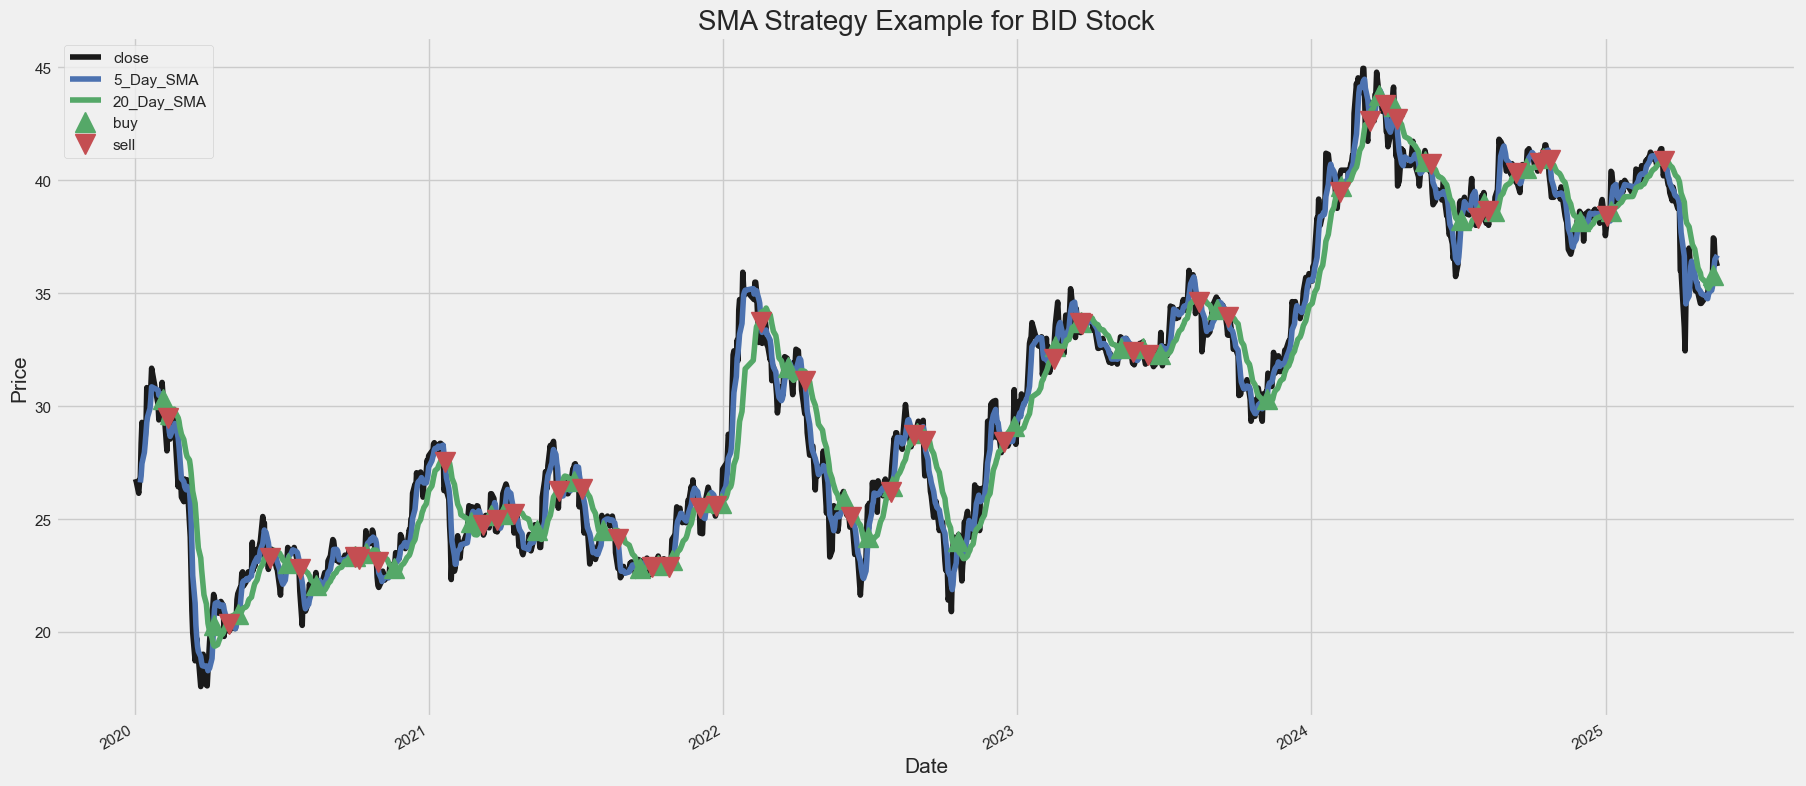

In [43]:
# Fix date index issue
BID = stocks[stocks['ticker'] == 'BID'].copy()
BID = BID[BID['time'] > '2020-01-01']
BID.set_index('time', inplace=True)

plt.figure(figsize = (20,10))
# plot close price, short-term and long-term moving averages 
BID['close'].plot(color = 'k', label= 'close') 
BID['SMA_5'].plot(color = 'b',label = '5_Day_SMA') 
BID['SMA_20'].plot(color = 'g', label = '20_Day_SMA')
# plot buy signals
plt.plot(BID[BID['SMA_Indicator_Position'] == 1].index, 
         BID['SMA_5'][BID['SMA_Indicator_Position'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
# plot sell signals
plt.plot(BID[BID['SMA_Indicator_Position'] == -1].index, 
         BID['SMA_5'][BID['SMA_Indicator_Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Price', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('SMA Strategy Example for BID Stock', fontsize = 20)
plt.legend()
plt.show()

## Simple Moving Average (Volume)

In [44]:
#Short term window Moving Avg (1 trading week)
stocks['SMA_Volume_5'] = stocks.groupby('ticker')['volume'].transform(lambda x: x.rolling(window = 5).mean())
#Long term window Moving Avg (1 trading month)
stocks['SMA_Volume_20'] = stocks.groupby('ticker')['volume'].transform(lambda x: x.rolling(window = 20).mean())
#Check for Golden Cross (when short term moving average crosses above long term), aka: when the ratio < 1
stocks['SMA_Volume_Ratio'] = stocks['SMA_Volume_20'] / stocks['SMA_Volume_5']

#Strategy:
#If SMA_Volume_Ratio < 1 THEN BUY
stocks['SMA_Vol_Indicator_Action'] = np.where(stocks['SMA_Volume_Ratio'] < 1, 1.0,0.0)
stocks['SMA_Vol_Indicator_Position'] = stocks['SMA_Vol_Indicator_Action'].diff()

### Example Plot

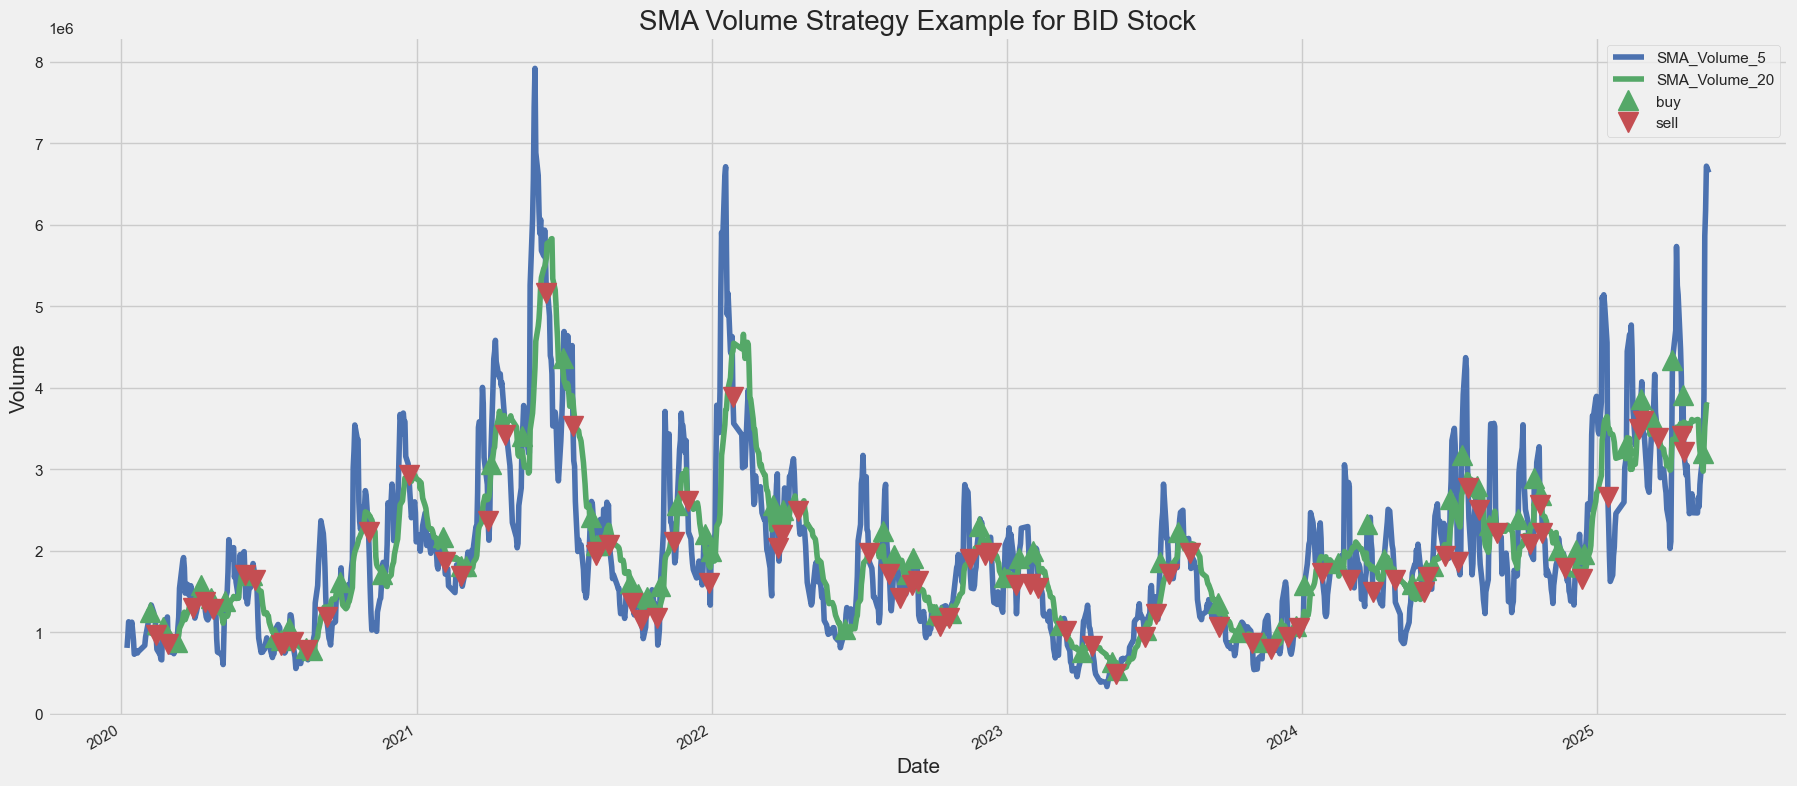

In [45]:
BID = stocks[stocks['ticker'] == 'BID'].copy()
BID = BID[BID['time'] > '2020-01-01']
BID.set_index('time', inplace=True)

plt.figure(figsize = (20,10))
# plot close price, short-term and long-term moving averages 
BID['SMA_Volume_5'].plot(color = 'b',label = 'SMA_Volume_5') 
BID['SMA_Volume_20'].plot(color = 'g', label = 'SMA_Volume_20')
# plot buy signals
plt.plot(BID[BID['SMA_Vol_Indicator_Position'] == 1].index, 
         BID['SMA_Volume_5'][BID['SMA_Vol_Indicator_Position'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
# plot sell signals
plt.plot(BID[BID['SMA_Vol_Indicator_Position'] == -1].index, 
         BID['SMA_Volume_5'][BID['SMA_Vol_Indicator_Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Volume', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('SMA Volume Strategy Example for BID Stock', fontsize = 20)
plt.legend()
plt.show()

## Average True Range (ATR)

In [46]:
#ATR is a measure of volatility so we want to exit when there is high volatility 
#Calculate True Range
stocks['TR'] = np.maximum((stocks['high'] - stocks['low']), 
                     np.maximum(abs(stocks['high'] - stocks['close'].shift(1)), 
                     abs(stocks['low'] - stocks['close'].shift(1))))
#Short term window ATR (1 trading week)
stocks['ATR_5'] = stocks.groupby('ticker')['TR'].transform(lambda x: x.rolling(window = 5).mean())
#Long term window Moving Avg (1 trading month)
stocks['ATR_20'] = stocks.groupby('ticker')['TR'].transform(lambda x: x.rolling(window = 20).mean())
#Check for Inflection and high volatility (when short term ATR crosses above long term), aka: when the ratio < 1
stocks['ATR_Ratio'] = stocks['ATR_20'] / stocks['ATR_5']

#Strategy:
#If ATR_Ratio < 1 THEN BUY
stocks['ATR_Indicator_Action'] = np.where(stocks['ATR_Ratio'] < 1, 1.0,0.0)
stocks['ATR_Indicator_Position'] = stocks['ATR_Indicator_Action'].diff()    

## Example Plot

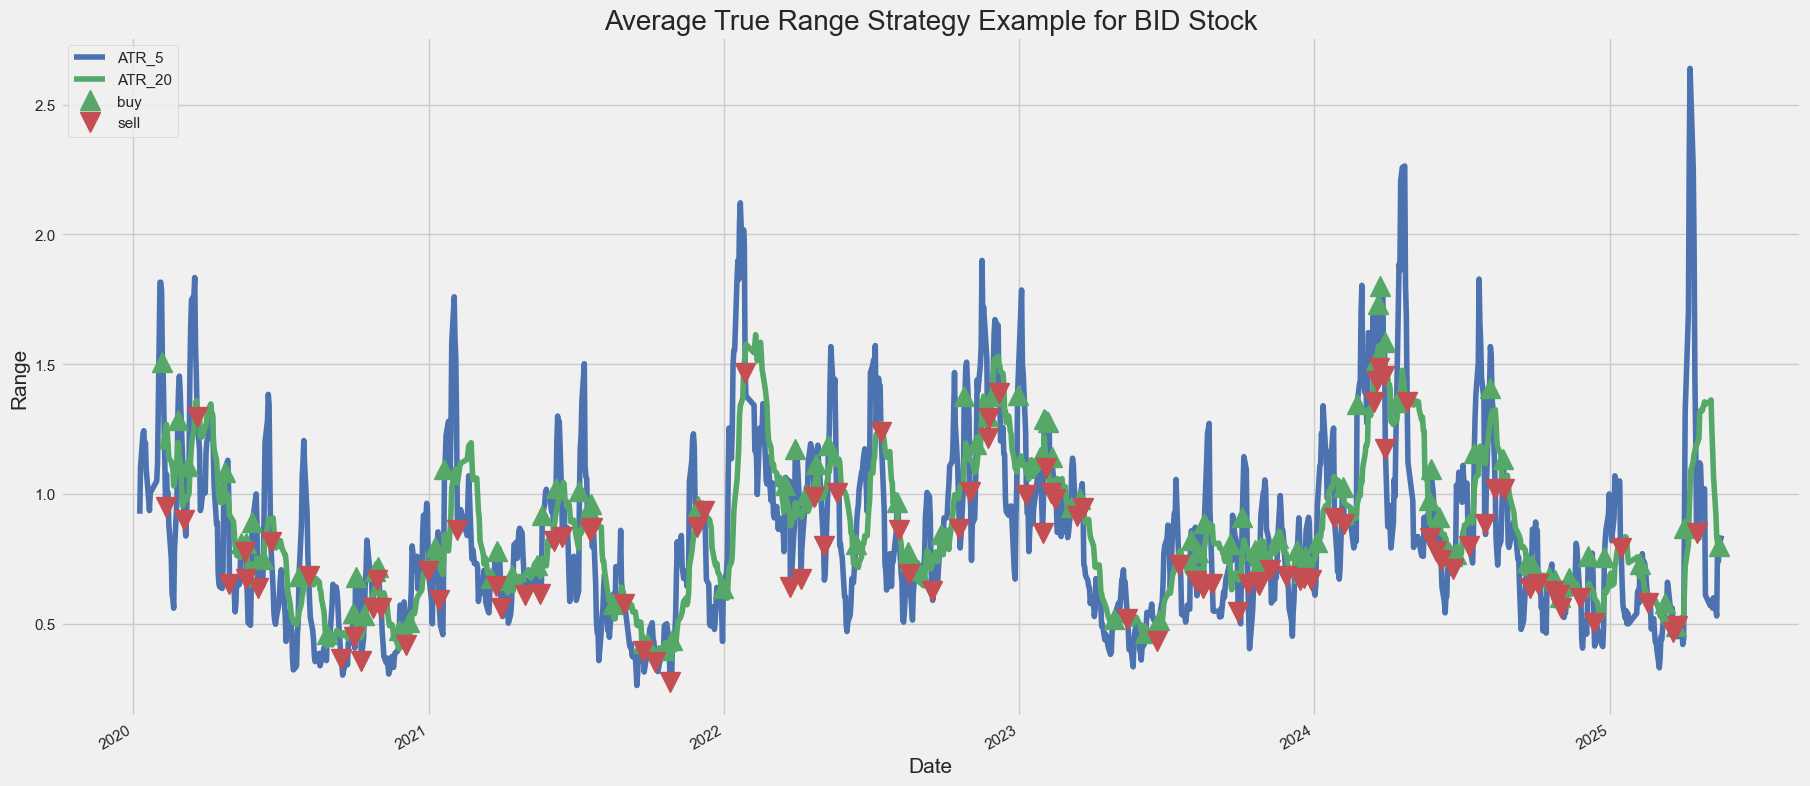

In [47]:
BID = stocks[stocks['ticker'] == 'BID'].copy()
BID = BID[BID['time'] > '2020-01-01']
BID.set_index('time', inplace=True)

plt.figure(figsize = (20,10))
# plot ATR ratio, short-term and long-term moving averages 
BID['ATR_5'].plot(color = 'b',label = 'ATR_5') 
BID['ATR_20'].plot(color = 'g', label = 'ATR_20')
# plot buy signals
plt.plot(BID[BID['ATR_Indicator_Position'] == 1].index, 
         BID['ATR_5'][BID['ATR_Indicator_Position'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
# plot sell signals
plt.plot(BID[BID['ATR_Indicator_Position'] == -1].index, 
         BID['ATR_5'][BID['ATR_Indicator_Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Range', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Average True Range Strategy Example for BID Stock', fontsize = 20)
plt.legend()
plt.show()

## Stochastic Oscillators

In [48]:
#Calculate 20 day highs/lows
stocks['20Day_Low'] = stocks.groupby('ticker')['low'].transform(lambda x: x.rolling(window = 20).min())
stocks['20Day_High'] = stocks.groupby('ticker')['high'].transform(lambda x: x.rolling(window = 20).max())
#Calculate Stochastic Oscillator Formula for %K line
stocks['20Day_%K'] = ((stocks['close'] - stocks['20Day_Low'])/(stocks['20Day_High'] - stocks['20Day_Low']))*100
#Calculate Stochastic Oscillator Formula for %D line
stocks['20Day_%D'] = stocks['20Day_%K'].rolling(window = 3).mean()

#Strategy:
#If 20Day_%K < 30 AND 20Day_%D < 30 THEN BUY
#If 20Day_%K > 70 AND 20Day_%D > 70 THEN SELL

## Example Plot

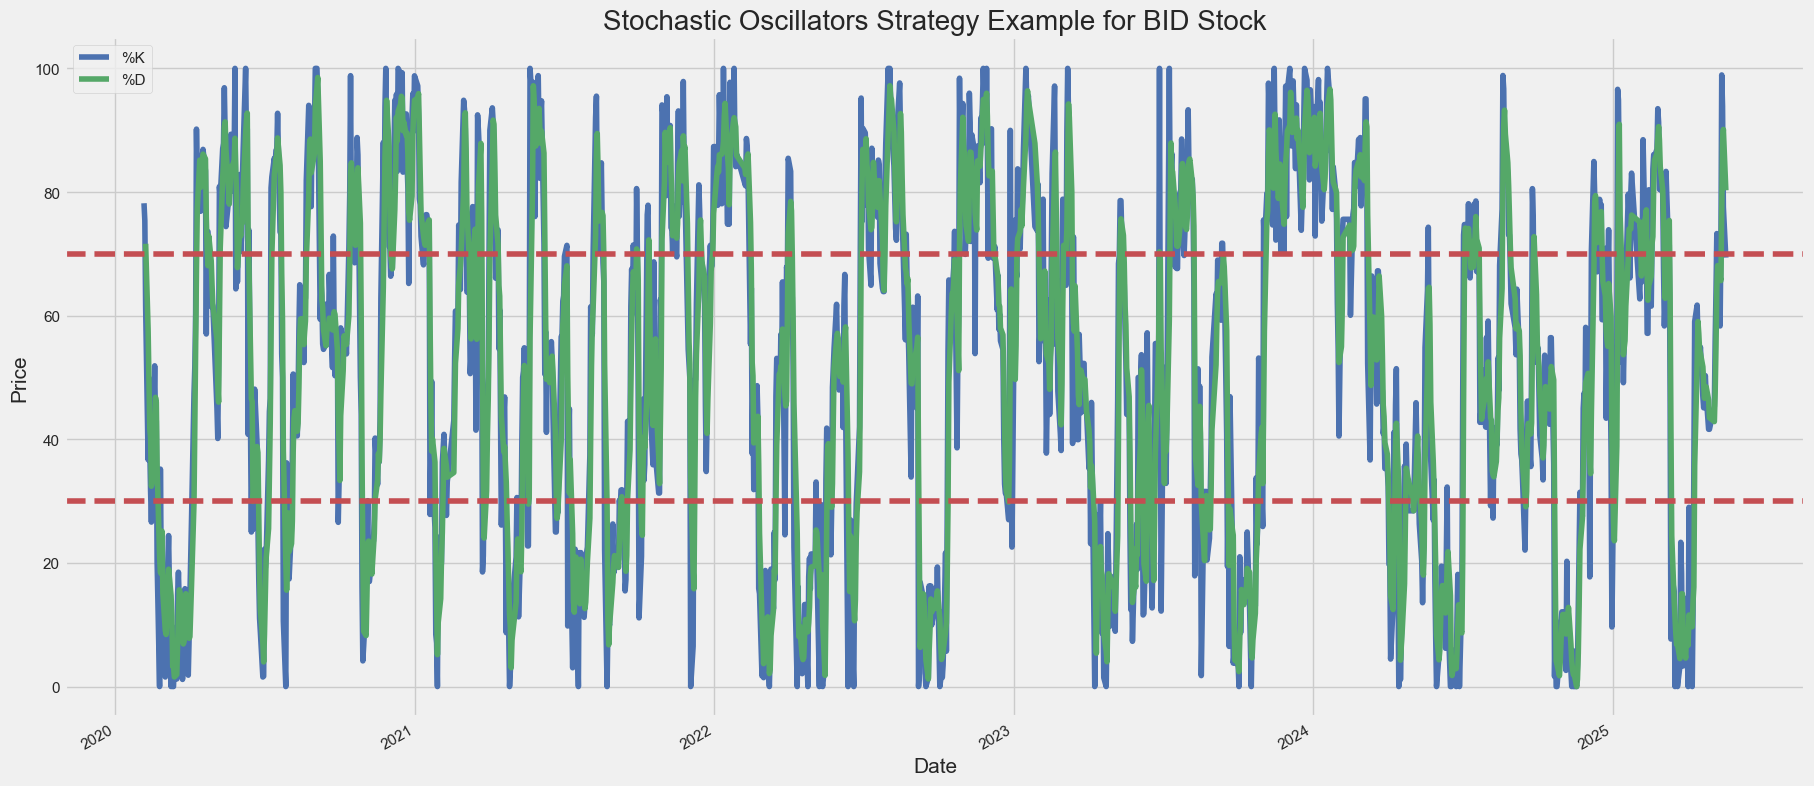

In [49]:
BID = stocks[stocks['ticker'] == 'BID'].copy()
BID = BID[BID['time'] > '2020-01-01']
BID.set_index('time', inplace=True)

plt.figure(figsize = (20,10))
# plot adjusted clost, %K and %D lines
BID['20Day_%K'].plot(color = 'b', label= '%K') 
BID['20Day_%D'].plot(color = 'g',label = '%D') 

plt.ylabel('Price', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Stochastic Oscillators Strategy Example for BID Stock', fontsize = 20)
plt.axhline(30, linestyle='--', color="r")
plt.axhline(70, linestyle="--", color="r")
plt.legend()
plt.show()

## Relative Strength Index (RSI)

In [50]:
# Calculate gains and losses and averages over 20 day period
stocks['diff'] = stocks.groupby('ticker')['close'].transform(lambda x: x.diff())
stocks['gain'] = stocks['diff'].clip(lower=0).round(2)
stocks['loss'] = stocks['diff'].clip(upper=0).abs().round(2)
stocks['avg_gain20'] = stocks.groupby('ticker')['gain'].transform(lambda x: x.rolling(window=20).mean())
stocks['avg_loss20'] = stocks.groupby('ticker')['loss'].transform(lambda x: x.rolling(window=20).mean())
#Calculate RS value
stocks['RS_20'] = stocks['avg_gain20'] / stocks['avg_loss20']
#Calculate RSI value
stocks['RSI_20'] = 100 - (100/(1+stocks['RS_20']))

#Strategy:
#If RSI_20 < 30 THEN BUY
#If RSI_20 > 70 THEN SELL

## Example Plot

Text(0.5, 0, 'Date')

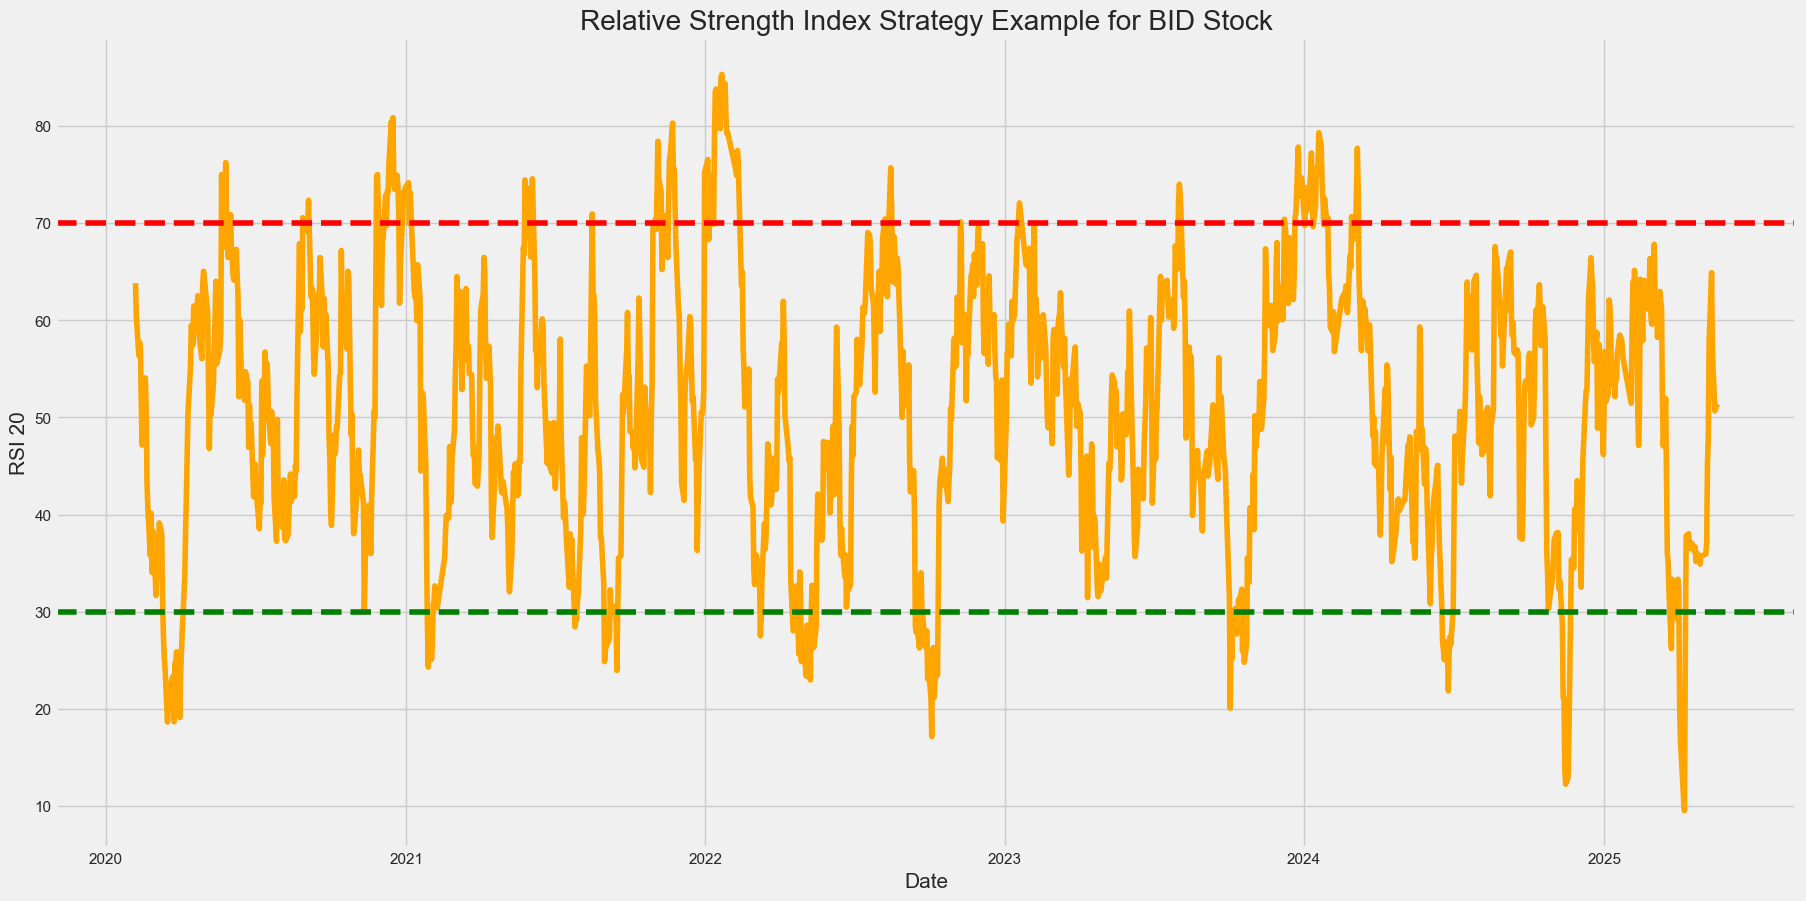

In [51]:
BID = stocks[stocks['ticker'] == 'BID'].copy()
BID = BID[BID['time'] > '2020-01-01']
BID.set_index('time', inplace=True)

plt.figure(figsize = (20,10))
# Plot the RSI
plt.title('Relative Strength Index Strategy Example for BID Stock')
plt.plot(BID['RSI_20'], color='orange')
# Oversold
plt.axhline(30, linestyle='--', color='green')
# Overbought
plt.axhline(70, linestyle='--', color='red')
plt.ylabel('RSI 20', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )


## Moving Average Convergence Divergence (MACD)

In [52]:
#Calculate 5 and 20 day Exponential Moving Averages
stocks['5Day_EMA'] = stocks.groupby('ticker')['close'].transform(lambda x: x.ewm(span=5, adjust=False).mean())
stocks['20Day_EMA'] = stocks.groupby('ticker')['close'].transform(lambda x: x.ewm(span=20, adjust=False).mean())
#Calculate MACD Value
stocks['MACD_Value'] = stocks['20Day_EMA'] - stocks['5Day_EMA']
#Calculate 5 day MACD Signal
stocks['MACD_Signal'] = stocks.groupby('ticker')['MACD_Value'].transform(lambda x: x.ewm(span=5, adjust=False).mean())

#Strategy:
#If MACD_Value > MACD_Signal THEN BUY
##If MACD_Signal > MACD_Value THEN SELL
stocks['MACD_Signal_Action'] = np.where(stocks['MACD_Value'] > stocks['MACD_Signal'], 1.0,0.0)
stocks['MACD_Signal_Position'] = stocks['MACD_Signal_Action'].diff()

## Example Plot

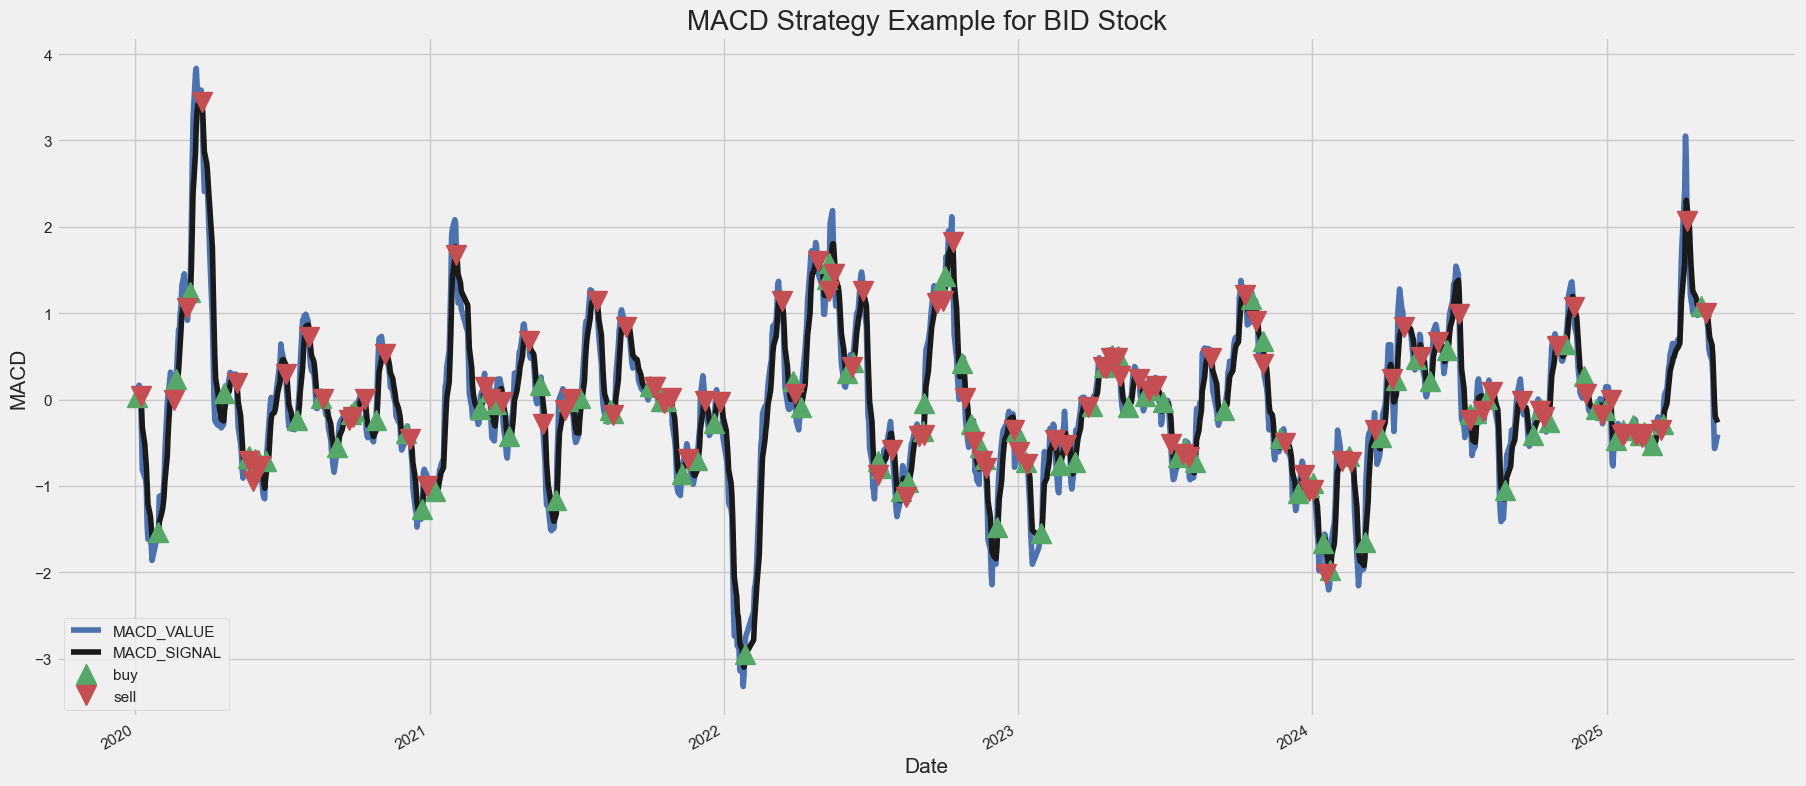

In [53]:
BID = stocks[stocks['ticker'] == 'BID'].copy()
BID = BID[BID['time'] > '2020-01-01']
BID.set_index('time', inplace=True)

plt.figure(figsize = (20,10))
# plot RSI line
BID['MACD_Value'].plot(color = 'b', label= 'MACD_VALUE') 
BID['MACD_Signal'].plot(color = 'k', label= 'MACD_SIGNAL') 

# plot buy signals
plt.plot(BID[BID['MACD_Signal_Position'] == 1].index, 
         BID['MACD_Value'][BID['MACD_Signal_Position'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
# plot sell signals
plt.plot(BID[BID['MACD_Signal_Position'] == -1].index, 
         BID['MACD_Value'][BID['MACD_Signal_Position']  == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('MACD', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('MACD Strategy Example for BID Stock', fontsize = 20)
plt.legend()
plt.show()

## Bollinger Bands

In [54]:
#Calculate 20 day moving avg and std 
stocks['SMA_20'] = stocks.groupby('ticker')['close'].transform(lambda x: x.rolling(window = 20).mean())
stocks['SD_20'] = stocks.groupby('ticker')['close'].transform(lambda x: x.rolling(window=20).std())
#calculate upper and lower bands 
stocks['upperband'] = stocks['SMA_20'] + 2*stocks['SD_20']
stocks['lowerband'] = stocks['SMA_20'] - 2*stocks['SD_20']

#Strategy:
#If close > upperband THEN SELL
#If close < lowerband THEN BUY
stocks['Bollinger_Signal_Action'] = np.where(stocks['lowerband'] > stocks['close'], 1.0,0.0)
stocks['Bollinger_Signal_Position'] = stocks['Bollinger_Signal_Action'].diff()

## Example Plot

<Figure size 2000x1000 with 0 Axes>

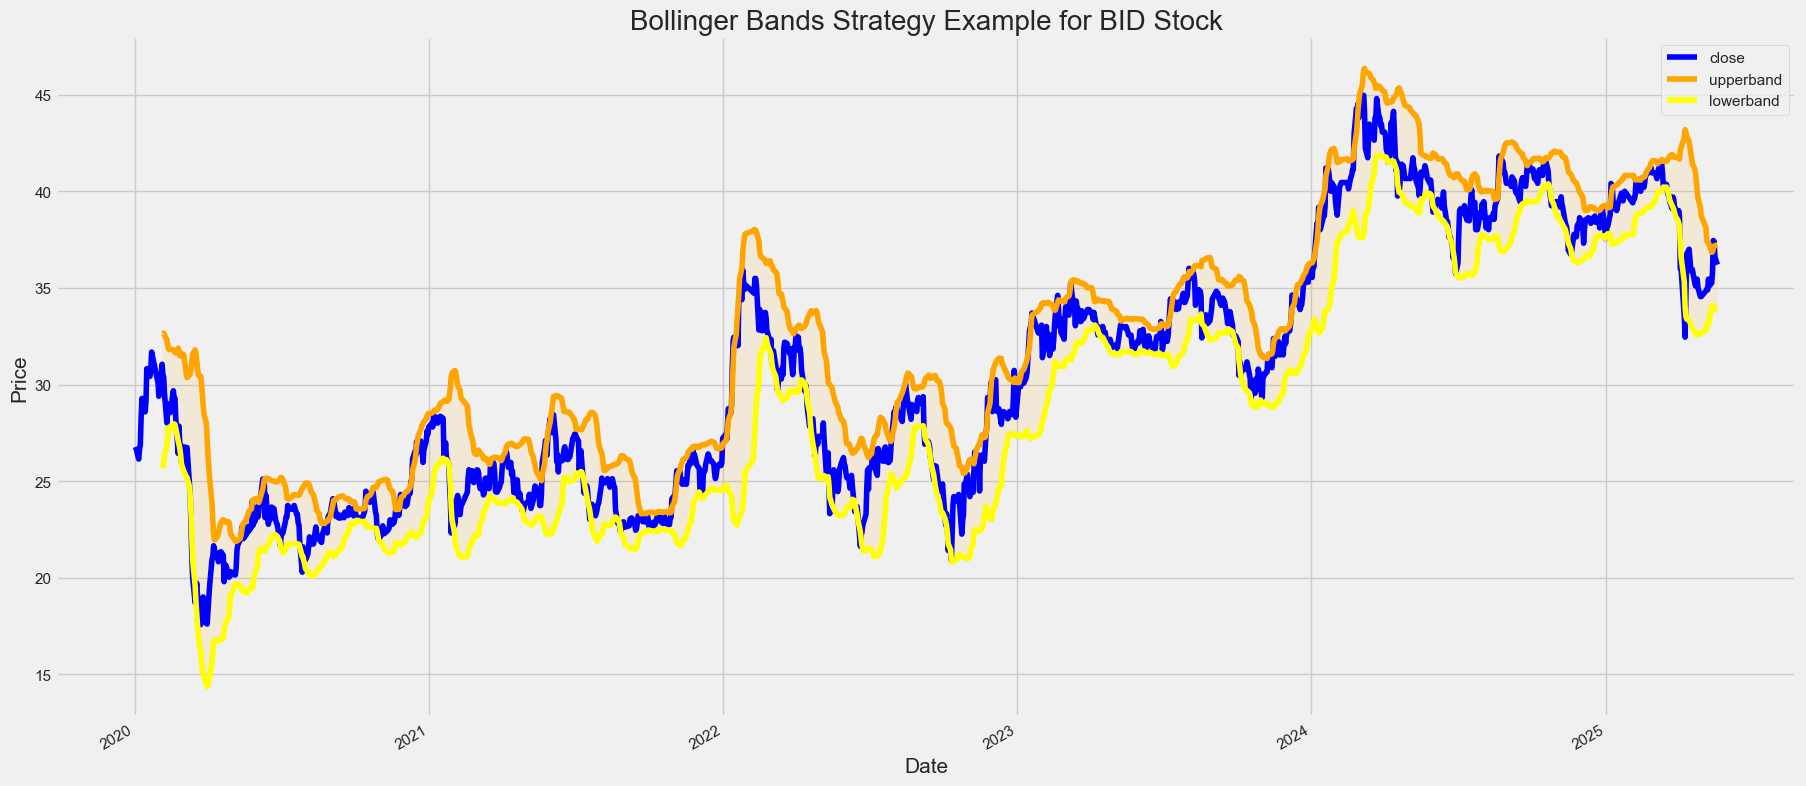

In [55]:
import pandas_datareader as pdr
import datetime as dt
import matplotlib.pyplot as plt

BID = stocks[stocks['ticker'] == 'BID'].copy()
BID = BID[BID['time'] > '2020-01-01']
BID.set_index('time', inplace=True)

plt.figure(figsize = (20,10))

ax = BID[['close', 'upperband', 'lowerband']].plot(color=['blue', 'orange', 'yellow'])
ax.fill_between(BID.index, BID['lowerband'], BID['upperband'], facecolor='orange', alpha=0.1)
plt.ylabel('Price', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Bollinger Bands Strategy Example for BID Stock', fontsize = 20)
plt.show()

In [56]:
#View complete dataframe
stocks.head(10)

,time,open,high,low,close,volume,ticker,returns,SMA_5,SMA_20,...,20Day_EMA,MACD_Value,MACD_Signal,MACD_Signal_Action,MACD_Signal_Position,SD_20,upperband,lowerband,Bollinger_Signal_Action,Bollinger_Signal_Position
24102,2020-01-02,26.25,26.94,26.20,26.77,872620,BID,NaN,NaN,NaN,...,26.770000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,0.0,NaN
24103,2020-01-03,27.02,27.11,26.65,26.65,603940,BID,-0.004483,NaN,NaN,...,26.758571,0.028571,0.009524,1.0,1.0,NaN,NaN,NaN,0.0,0.0
24104,2020-01-06,26.54,26.65,26.14,26.14,794490,BID,-0.019137,NaN,NaN,...,26.699660,0.166327,0.061791,1.0,0.0,NaN,NaN,NaN,0.0,0.0
24105,2020-01-07,26.14,26.65,25.80,26.65,526890,BID,0.019510,NaN,NaN,...,26.694930,0.122708,0.082097,1.0,0.0,NaN,NaN,NaN,0.0,0.0
24106,2020-01-08,26.25,27.34,26.14,26.88,1230830,BID,0.008630,26.618,NaN,...,26.712556,0.037741,0.067312,0.0,-1.0,NaN,NaN,NaN,0.0,0.0
24107,2020-01-09,27.25,28.48,27.17,28.34,1573190,BID,0.054315,26.932,NaN,...,26.867551,-0.362326,-0.075901,0.0,0.0,NaN,NaN,NaN,0.0,0.0
24108,2020-01-10,28.34,29.68,28.31,29.28,1506410,BID,0.033169,27.458,NaN,...,27.097308,-0.815943,-0.322582,0.0,0.0,NaN,NaN,NaN,0.0,0.0
24109,2020-01-13,28.54,29.39,28.25,28.59,544740,BID,-0.023566,27.948,NaN,...,27.239469,-0.899365,-0.514843,0.0,0.0,NaN,NaN,NaN,0.0,0.0
24110,2020-01-14,28.59,29.39,28.48,28.59,752200,BID,0.000000,28.336,NaN,...,27.368091,-0.921132,-0.650272,0.0,0.0,NaN,NaN,NaN,0.0,0.0
24111,2020-01-15,28.48,29.28,28.48,29.11,695290,BID,0.018188,28.782,NaN,...,27.533987,-1.028828,-0.776458,0.0,0.0,NaN,NaN,NaN,0.0,0.0


# TRADING STRATEGY

##### The method involves combining all technical indicators to generate buy and sell signals, requiring all buy signals to be true in order to enter a position, while a single true sell signal is sufficient to exit. The analysis is conducted over the full date range from January 1, 2020, to the present. A performance DataFrame is created to track individual trade profits and compare them to a SPY buy-and-hold benchmark. Additionally, an aggregate DataFrame summarizes total profit, profit percentage, and HOSE-relative performance for each stock. The top 25 stocks by performance are then sorted and ranked to identify which sectors the model performs best in. A sector-focused DataFrame is built from these top performers, followed by the calculation of optimal risk allocation and portfolio weighting. Finally, total portfolio profits and a final benchmark comparison are computed.

In [57]:
from vnstock import Vnstock

# Data retrived of VNINDEX
vnindex_data = Vnstock().stock(symbol='VNINDEX', source='VCI').quote.history(start='2020-01-01', end='2025-05-19')
vnindex_data['time'] = pd.to_datetime(vnindex_data['time'])
vnindex_data.sort_values(by='time', inplace=True)
vnindex_data.set_index('time', inplace=True)


2025-05-19 22:02:57 - vnstock.common.data.data_explorer - INFO - Không phải là mã chứng khoán, thông tin công ty và tài chính không khả dụng.


In [58]:
# Benchmark function using VNINDEX (not SPY)
def benchmark_stats(starting_date, total_investment_value):
    vnindex = vnindex_data[vnindex_data.index >= pd.to_datetime(starting_date)].copy()
    BENCH = vnindex_data['close'].reset_index(drop=True)
    benchmark = pd.DataFrame(np.diff(BENCH)).rename(columns={0: 'benchmark_returns'})
    total_stocks = floor(total_investment_value / BENCH[0])
    benchmark_investment_return = [total_stocks * r for r in benchmark['benchmark_returns']]
    return pd.DataFrame(benchmark_investment_return, columns=['investment_returns'])

# Choose starting date and capital
benchmark = benchmark_stats('2020-01-01', 100000)
year = '2000-01-01'
total_investment_value = 100000
total_benchmark_investment_returns = round(sum(benchmark['investment_returns']), 2)
benchmark_profit_percentage = floor((total_benchmark_investment_returns / total_investment_value) * 100)

# Display benchmark performance
print(f'Benchmark Stats from date {year} to present using an initial investment amount of ${total_investment_value}:')
print(f'Benchmark profit dollar amount ${total_benchmark_investment_returns}')
print(f'Benchmark profit percentage amount: {benchmark_profit_percentage}%')
print()

# Return tracking DataFrame
returns_df = pd.DataFrame(columns=['Ticker', 'Profit Gained', 'Profit Percentage', 'Benchmark Profit Comparison'])

# Loop through all stocks
for stock_ticker in stocks['ticker'].unique():
    stock = stocks[(stocks['ticker'] == stock_ticker) & (stocks['time'] > '2020-01-01')].copy()
    stock.set_index('time', inplace=True)

    def trading_strategy(prices, SMA_Ratio, SMA_Volume_Ratio, ATR_Ratio, Day20_K, Day20_D, RSI_20, MACD_Value, MACD_Signal, upperband, lowerband):    
        buy_price, sell_price, trading_signal = [], [], []
        signal = 0
        for i in range(len(prices)):
            if (SMA_Ratio[i] < 1) & (SMA_Volume_Ratio[i] < 1) & (ATR_Ratio[i] < 1) & (Day20_K[i] < 30) & (Day20_D[i] < 30) \
               & (RSI_20[i] < 30) & (MACD_Value[i] > MACD_Signal[i]) & (prices[i] < lowerband[i]):
                if signal != 1:
                    buy_price.append(prices[i])
                    sell_price.append(np.nan)
                    signal = 1
                    trading_signal.append(signal)
                else:
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    trading_signal.append(0)
            elif (SMA_Ratio[i] > 1) | (SMA_Volume_Ratio[i] > 1) | (ATR_Ratio[i] > 1) | (Day20_K[i] > 70) | (Day20_D[i] > 70) \
                 | (RSI_20[i] > 70) | (MACD_Value[i] < MACD_Signal[i]) | (prices[i] > upperband[i]):
                if signal != -1 and signal != 0:
                    buy_price.append(np.nan)
                    sell_price.append(prices[i])
                    signal = -1
                    trading_signal.append(signal)
                else:
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    trading_signal.append(0)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                trading_signal.append(0)
        return buy_price, sell_price, trading_signal

    # Generate trading signal
    buy_price, sell_price, trading_signal = trading_strategy(stock['close'], stock['SMA_Ratio'], stock['SMA_Volume_Ratio'],
                                                             stock['ATR_Ratio'], stock['20Day_%K'], stock['20Day_%D'], stock['RSI_20'],
                                                             stock['MACD_Value'], stock['MACD_Signal'], stock['upperband'], stock['lowerband'])

    # Generate trading position
    position = [1] * len(trading_signal)
    for i in range(1, len(trading_signal)):
        if trading_signal[i] == 1:
            position[i] = 1
        elif trading_signal[i] == -1:
            position[i] = 0
        else:
            position[i] = position[i-1]

    # Build strategy DataFrame
    trading_signal_df = pd.DataFrame(trading_signal, index=stock.index, columns=['trading_signal'])
    position_df = pd.DataFrame(position, index=stock.index, columns=['trading_position'])

    frames = [
        stock['close'], stock['SMA_Ratio'], stock['SMA_Volume_Ratio'], stock['ATR_Ratio'],
        stock['20Day_%K'], stock['20Day_%D'], stock['RSI_20'], stock['MACD_Value'], stock['MACD_Signal'],
        stock['upperband'], stock['lowerband'], trading_signal_df, position_df
    ]
    strategy = pd.concat(frames, axis=1)

    # Backtest
    stock_ret = pd.DataFrame(np.diff(stock['close'])).rename(columns={0: 'returns'})
    trading_strategy_ret = [stock_ret['returns'][i] * strategy['trading_position'].iloc[i] for i in range(len(stock_ret))]
    trading_strategy_ret_df = pd.DataFrame(trading_strategy_ret, columns=['trading_returns'])

    # Calculate investment returns
    investment_value = 100000
    number_of_stocks = floor(investment_value / stock['close'].iloc[0])
    trading_investment_ret = [number_of_stocks * r for r in trading_strategy_ret_df['trading_returns']]
    trading_investment_ret_df = pd.DataFrame(trading_investment_ret, columns=['investment_returns'])
    
    total_investment_ret = round(sum(trading_investment_ret_df['investment_returns']), 2)
    profit_percentage = floor((total_investment_ret / investment_value) * 100)
    benchmark_comparison = profit_percentage - benchmark_profit_percentage

    # Add result to summary DataFrame
    returns_df.loc[len(returns_df)] = {
    'Ticker': stock_ticker,
    'Profit Gained': total_investment_ret,
    'Profit Percentage': profit_percentage,
    'Benchmark Profit Comparison': benchmark_comparison
    }

# Final results
returns_df


Benchmark Stats from date 2000-01-01 to present using an initial investment amount of $100000:
Benchmark profit dollar amount $33950.86
Benchmark profit percentage amount: 33%



Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

,Ticker,Profit Gained,Profit Percentage,Benchmark Profit Comparison
0,BID,35221.05,35,2
1,BVH,-19558.84,-20,-53
2,CTG,172458.00,172,139
3,FPT,376361.70,376,343
4,GAS,-2535.90,-3,-36
5,HDB,208974.72,208,175
6,HPG,158300.40,158,125
7,KDH,71395.20,71,38
8,MBB,199630.20,199,166
9,MSN,34427.84,34,1


In [59]:
#Add industry label
from vnstock import Screener
screener = Screener()
df_screener = screener.stock(params={"exchangeName": "HOSE"}, limit=1700)
returns_df['Ticker'] = returns_df['Ticker'].str.upper()
df_screener = df_screener[['ticker', 'industry']].drop_duplicates()
df_screener.rename(columns={'ticker': 'Ticker', 'industry': 'Industry'}, inplace=True)
returns_df = returns_df.merge(df_screener, on='Ticker', how='left')
returns_df

,Ticker,Profit Gained,Profit Percentage,Benchmark Profit Comparison,Industry
0,BID,35221.05,35,2,Ngân hàng
1,BVH,-19558.84,-20,-53,Bảo hiểm
2,CTG,172458.00,172,139,Ngân hàng
3,FPT,376361.70,376,343,Công nghệ Thông tin
4,GAS,-2535.90,-3,-36,"Điện, nước & xăng dầu khí đốt"
5,HDB,208974.72,208,175,Ngân hàng
6,HPG,158300.40,158,125,Tài nguyên Cơ bản
7,KDH,71395.20,71,38,Bất động sản
8,MBB,199630.20,199,166,Ngân hàng
9,MSN,34427.84,34,1,Thực phẩm và đồ uống


In [62]:
# Filter Top 10 stock with highest returns 
top10_df = returns_df.sort_values('Profit Gained', ascending=False).head(10)

# Number of stock by industry in top 10
top10_industry_counts = top10_df['Industry'].value_counts()

# Number of stock by industry in whole dataset
total_industry_counts = returns_df['Industry'].value_counts()

#Industry ratios
industry_ratios = (top10_industry_counts / total_industry_counts).sort_values(ascending=False)
summary_df = pd.DataFrame({
    'Top 10 Count': top10_industry_counts,
    'Total Count': total_industry_counts,
    'Industry ratios': industry_ratios
}).fillna(0)

from IPython.display import display

display(summary_df)

,Top 10 Count,Total Count,Industry ratios
Industry,,,
Bán lẻ,0.0,1,0.000000
Bảo hiểm,0.0,1,0.000000
Bất động sản,0.0,6,0.000000
Công nghệ Thông tin,1.0,1,1.000000
Du lịch và Giải trí,0.0,1,0.000000
Dầu khí,0.0,1,0.000000
Dịch vụ tài chính,1.0,1,1.000000
Hàng & Dịch vụ Công nghiệp,1.0,1,1.000000
Hàng cá nhân & Gia dụng,0.0,1,0.000000


In [65]:
#Best pertforming sectors were by far Banking
#Create a new portfolio with only Banking from VN30
portfolio_df = returns_df[returns_df['Industry'] == 'Ngân hàng']
portfolio_df

,Ticker,Profit Gained,Profit Percentage,Benchmark Profit Comparison,Industry
0,BID,35221.05,35,2,Ngân hàng
2,CTG,172458.00,172,139,Ngân hàng
5,HDB,208974.72,208,175,Ngân hàng
8,MBB,199630.20,199,166,Ngân hàng
19,STB,282326.40,282,249,Ngân hàng
20,TCB,155623.40,155,122,Ngân hàng
22,TPB,112810.86,112,79,Ngân hàng
23,VCB,44335.32,44,11,Ngân hàng
28,VPB,171235.47,171,138,Ngân hàng


The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Text(0.5, 1.0, 'Efficient Frontier')

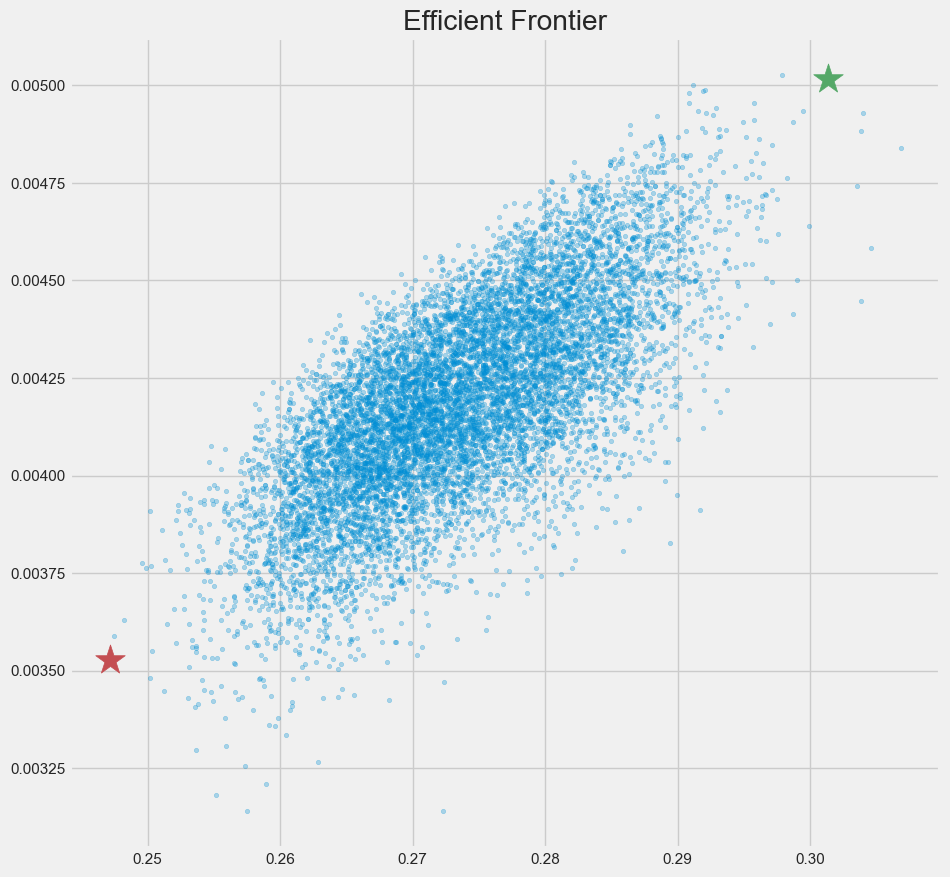

In [68]:
# Ensure datetime index
stocks['time'] = pd.to_datetime(stocks['time'])
stocks.set_index('time', inplace=True)
stocks.sort_index(inplace=True)

# Portfolio Risk, Weighting Calculations
portfolio_tickers = list(portfolio_df.Ticker.unique())
risk_df = stocks[(stocks['ticker'].isin(portfolio_tickers)) & (stocks.index >= '2020-01-01')]

stocks_min_risk = risk_df[['ticker','close']]
stocks_min_risk = pd.pivot(stocks_min_risk,columns = 'ticker', values = 'close')

cov_matrix = stocks_min_risk.pct_change().apply(lambda x: np.log(1+x)).cov()
corr_matrix = stocks_min_risk.pct_change().apply(lambda x: np.log(1+x)).corr()


# weekly returns for individual companies
ind_er = stocks_min_risk.resample('W').last().pct_change().mean()


p_ret = [] # portfolio returns
p_vol = [] # portfolio volatility
p_weights = [] # asset weights

num_assets = len(stocks_min_risk.columns)
num_portfolios = 10000


for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, ind_er)    
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    sd = np.sqrt(var)
    ann_sd = sd*np.sqrt(250) 
    p_vol.append(ann_sd)

data1 = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(stocks_min_risk.columns.tolist()):
    data1[symbol+' weight'] = [w[counter] for w in p_weights]
portfolios  = pd.DataFrame(data1)
portfolios.head()

min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
               
rf = 0.01 
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]

plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500)
plt.title("Efficient Frontier")

In [69]:
#Minimum Volatility Weight
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]

# Maximum Return Weight
# Finding the optimal portfolio
rf = 0.01 # risk factor
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
print('Maximum Return Weight: ')
print(optimal_risky_port)

Maximum Return Weight: 
Returns       0.005016
Volatility    0.301371
BID weight    0.006874
CTG weight    0.130198
HDB weight    0.036697
MBB weight    0.206089
STB weight    0.252609
TCB weight    0.203866
TPB weight    0.005010
VCB weight    0.012281
VPB weight    0.146375
Name: 2724, dtype: float64


In [70]:
#Add weights to final portfolio
portfolio_df = portfolio_df.sort_values('Ticker')
ticker_list = list(portfolio_df.Ticker)
weight_list = list(optimal_risky_port[2:])
weight_dict = dict(zip(ticker_list, weight_list))
weight_df = pd.DataFrame(weight_dict.items(), columns=['Ticker', 'Weight'])
final_portfolio_df = pd.merge(portfolio_df, weight_df, on='Ticker', how='outer')
final_portfolio_df

,Ticker,Profit Gained,Profit Percentage,Benchmark Profit Comparison,Industry,Weight
0,BID,35221.05,35,2,Ngân hàng,0.006874
1,CTG,172458.00,172,139,Ngân hàng,0.130198
2,HDB,208974.72,208,175,Ngân hàng,0.036697
3,MBB,199630.20,199,166,Ngân hàng,0.206089
4,STB,282326.40,282,249,Ngân hàng,0.252609
5,TCB,155623.40,155,122,Ngân hàng,0.203866
6,TPB,112810.86,112,79,Ngân hàng,0.005010
7,VCB,44335.32,44,11,Ngân hàng,0.012281
8,VPB,171235.47,171,138,Ngân hàng,0.146375


In [71]:
#Multiply weights by profit statistics 
final_portfolio_df['Profit Gained'] = final_portfolio_df['Profit Gained'] * final_portfolio_df['Weight']
final_portfolio_df['Profit Percentage'] = final_portfolio_df['Profit Percentage'] * final_portfolio_df['Weight']
final_portfolio_df['Benchmark Profit Comparison'] = final_portfolio_df['Benchmark Profit Comparison'] * final_portfolio_df['Weight']
final_portfolio_df

,Ticker,Profit Gained,Profit Percentage,Benchmark Profit Comparison,Industry,Weight
0,BID,242.105774,0.240586,0.013748,Ngân hàng,0.006874
1,CTG,22453.768707,22.394138,18.097588,Ngân hàng,0.130198
2,HDB,7668.757598,7.632988,6.421985,Ngân hàng,0.036697
3,MBB,41141.541452,41.011664,34.210735,Ngân hàng,0.206089
4,STB,71318.315101,71.235863,62.899752,Ngân hàng,0.252609
5,TCB,31726.254709,31.599165,24.871601,Ngân hàng,0.203866
6,TPB,565.237407,0.561175,0.395829,Ngân hàng,0.005010
7,VCB,544.474411,0.540356,0.135089,Ngân hàng,0.012281
8,VPB,25064.671773,25.030205,20.199814,Ngân hàng,0.146375


In [72]:
#Calculate Total Benchmark Profit Comparison of our Final weighted portfolio 
print('Our trading strategy outperformed a buy and hold VN30 strategy over the years 2020-01-01 to present day by', round(final_portfolio_df['Benchmark Profit Comparison'].sum(),2), '%')

Our trading strategy outperformed a buy and hold VN30 strategy over the years 2020-01-01 to present day by 167.25 %
